In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_features = pd.read_csv('./datasets/train_wManualFeatures.csv',index_col='Id')

In [3]:
train_features['Overall Qual_obj'] = train_features['Overall Qual_obj'].astype(object)
train_features['Overall Cond_obj'] = train_features['Overall Cond_obj'].astype(object)
train_features['MS SubClass'] = train_features['MS SubClass'].astype(object)

In [4]:
# function to create boxplots for a certain categorical variable, sorted by the median

def cat_plotter(x, df=train_features, kind='swarm',line=True, y='SalePrice'):
    
    order = list(pd.pivot_table(data=df, columns=x,
                    values=y, 
                    aggfunc=np.median).T.sort_values(by=y).reset_index()[x])
    
    plt.figure(figsize = (10,4))
    
    if kind == 'box':
    
        ax = sns.boxplot(x=x, y=y, data=df, order=order)
        
    elif kind == 'swarm':
        ax = sns.swarmplot(x=x, y=y, data=df, order=order)
        
    elif kind == 'both':
        ax = sns.boxplot(x=x, y=y, data=df, order=order,color='white')
        sns.swarmplot(x=x, y=y, data=df, order=order, ax=ax)
        
    
    if line:    
        sns.pointplot(x=x, y=y, data=df[[x, y]].groupby(x, as_index=False).median().sort_values(y), ax=ax)
        
    
    
    ax.set_title(x,fontsize=20)
    return ax

In [5]:
categorical = train_features.select_dtypes(include=['object','bool'])
numerical = train_features.select_dtypes(include=['float64','int'])

In [6]:
cat_dummies = pd.get_dummies(categorical)

In [7]:
numerical.shape

(2049, 40)

In [8]:
train_w_dummies = pd.concat([numerical, cat_dummies],axis=1)

In [9]:
train_w_dummies.shape

(2049, 353)

In [10]:
(train_w_dummies.corr().abs()>.8).sum().sort_values(ascending=False).head(20)

Bsmt Qual_None         6
BsmtFin Type 2_None    6
Bsmt Cond_None         6
Bsmt Exposure_None     6
HasBasement            6
BsmtFin Type 1_None    6
Total Living Space     6
Total SF               6
Garage Finish_None     5
Garage Qual_None       5
Garage Cond_None       5
Has_Garage             5
Qual_LivingArea        5
SalePrice              5
Garage Type_None       5
Gr Liv Area            3
Pool Area              3
Overall Qual           3
Has Fireplace          3
Fireplace Qu_None      3
dtype: int64

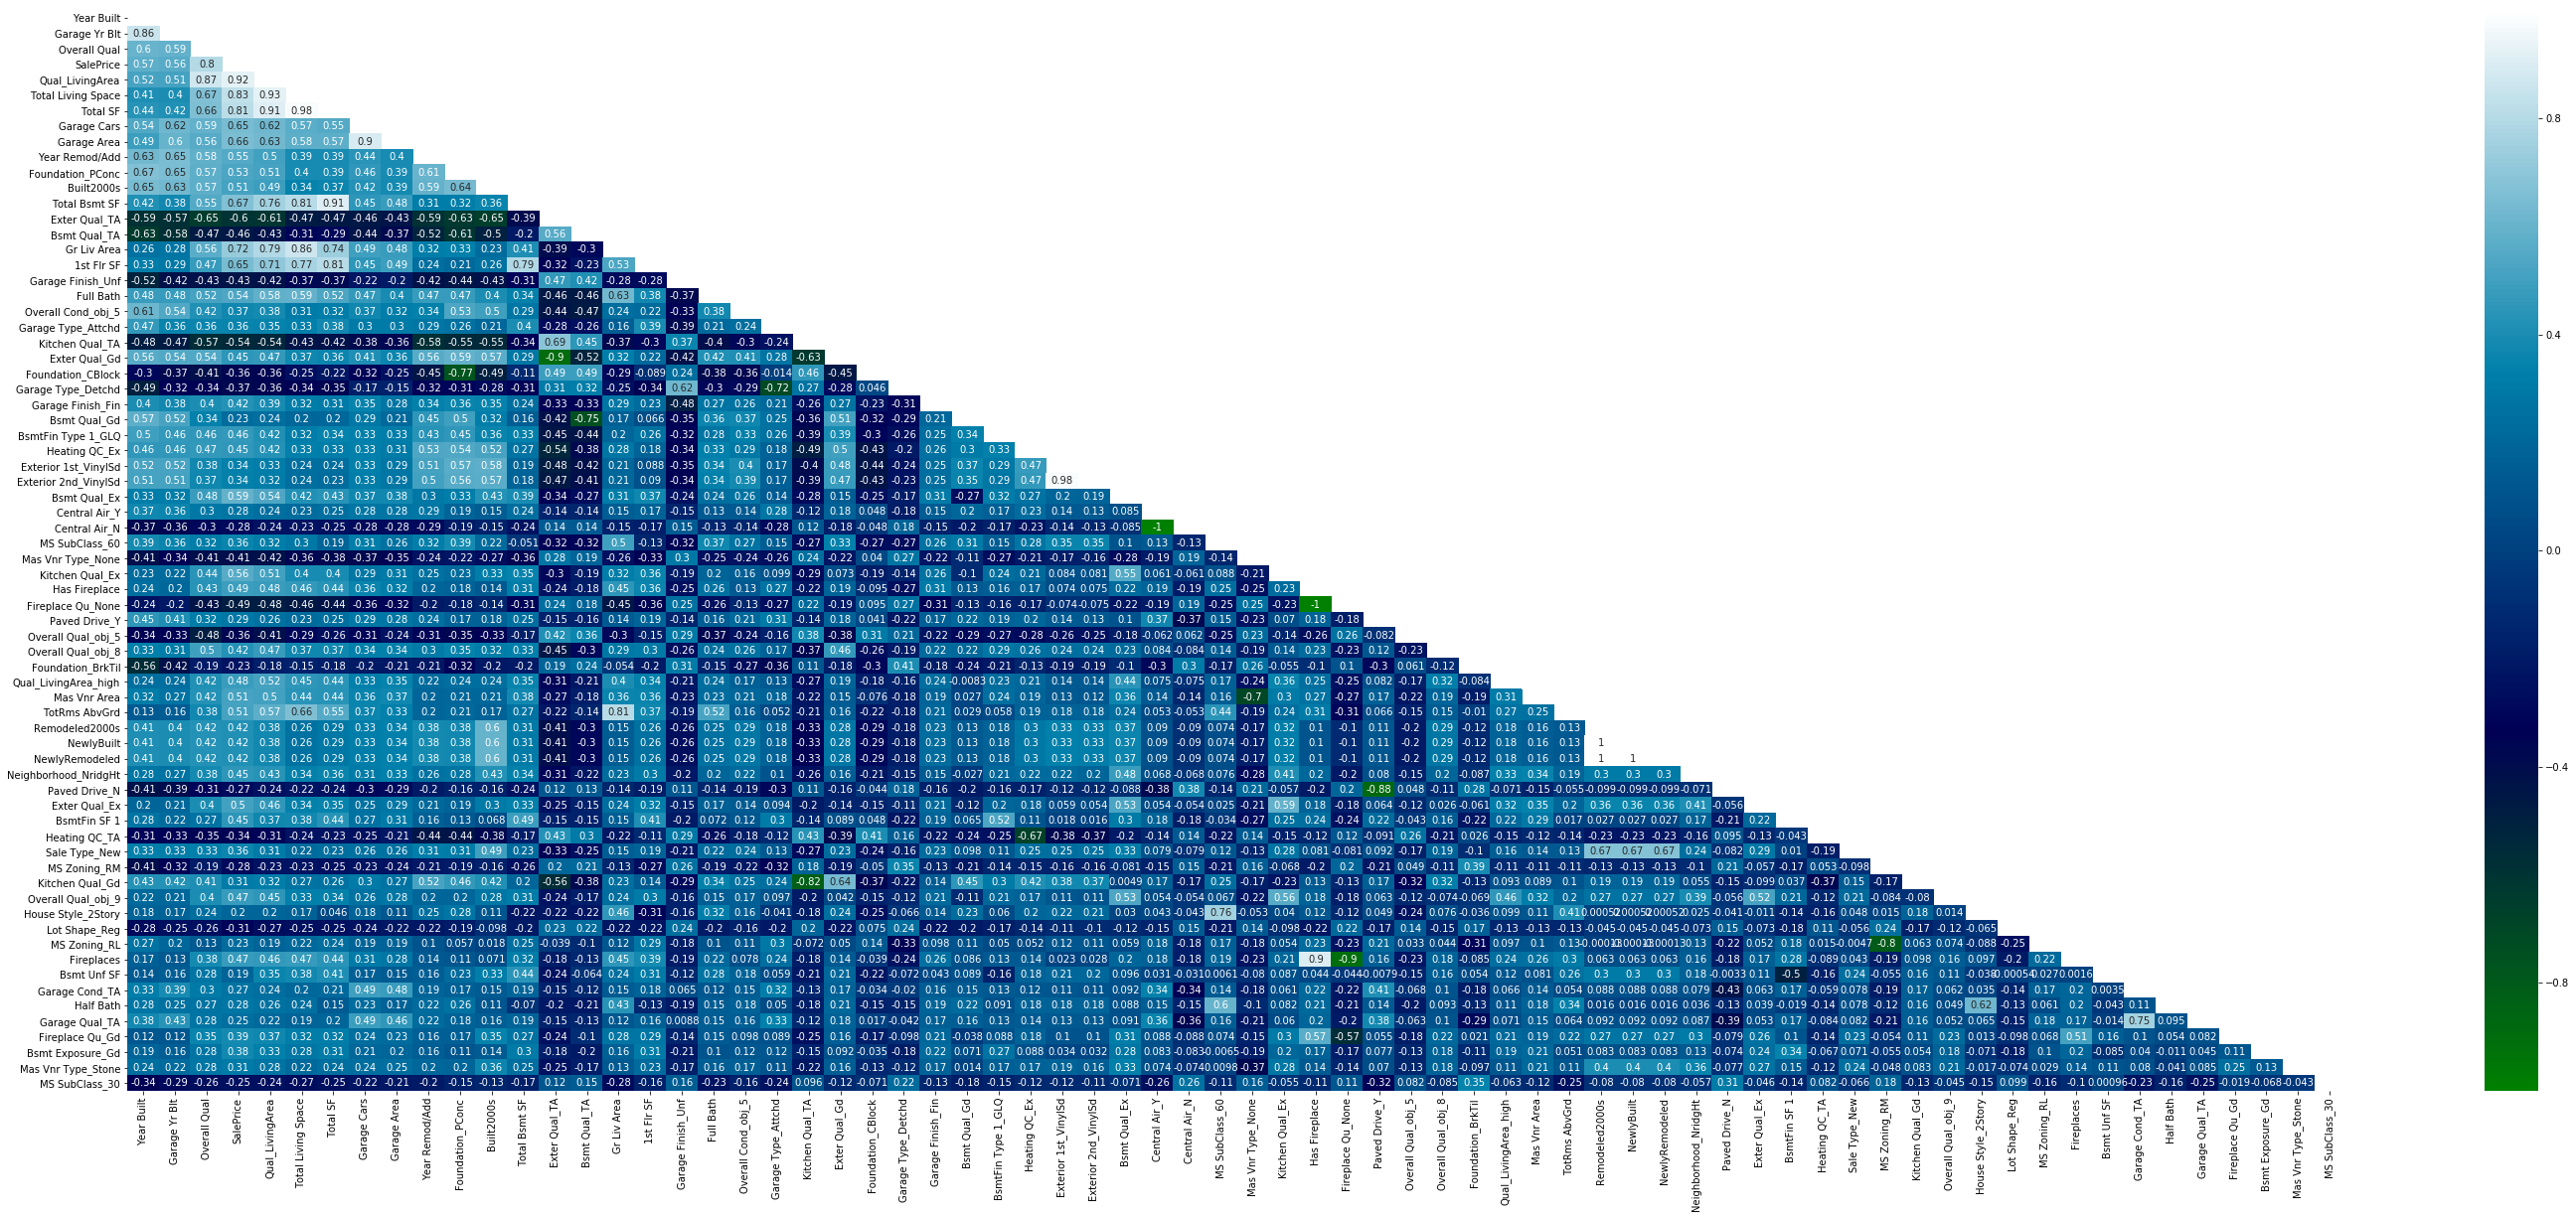

In [11]:
plt.figure(figsize = (50,20))

corr_attributes75 = (train_w_dummies.corr().abs()>.2).sum().sort_values(ascending=False).head(70).index.tolist()

mask = np.triu(np.ones_like(train_w_dummies[corr_attributes75].corr()))

sns.heatmap(train_w_dummies[corr_attributes75].corr(),annot=True, mask=mask, annot_kws={"size":10},cmap='ocean')

I am choosing a large amount of variables, anything with a .005 correlation to SalePrice. I will be using Lasso regularization, which will help to choose which variables are worth keeping in the model.

In [12]:
high_saleprice_corr = pd.DataFrame((train_w_dummies.corr().abs()>.005)['SalePrice'].sort_values(ascending=False))
high_saleprice_corr_cols = high_saleprice_corr.loc[high_saleprice_corr['SalePrice'] == 1].index.tolist()

### This heatmap shows two important things

- Qual LivingArea correlated HIGHLY with SalePrice
- All of the basement attributes correlate at the same level as each other, and are EXTREMELY co-linear. They all correspond to not having a basement.

In [13]:
broad_feat_selection = train_w_dummies[high_saleprice_corr_cols]

In [14]:
sorted_cols = broad_feat_selection.columns.tolist()
sorted_cols.sort()

In [15]:
cols_to_drop = ['Gr Liv Area','2nd Flr SF','1st Flr SF','Total Living Space','Lot Area','Garage Area','Total SF','Overall Qual']

In [16]:
for each in cols_to_drop:
    sorted_cols.remove(each)

In [17]:
broad_feat_selection[sorted_cols].to_csv('./datasets/good_features.csv')